In [1]:
SYSTEM = 'Al-Ni'
PHASE = 'BCC_B2'

In [2]:
import datetime
import time
import os
current_time = datetime.datetime.now()
print(current_time)
timestamp = str(time.mktime(current_time.timetuple()))
os.makedirs('output-results/{0}/{1}/'.format(PHASE, timestamp))

2015-11-30 13:26:22.532313


In [12]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('bmh')
from pycalphad.fitting import build_pymc_model, plot_results
from pycalphad import Database
import pymc
import numpy as np

/home/rotis/anaconda/envs/mc/lib/python2.7/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [4]:
import glob
input_database = Database(SYSTEM+'-start.tdb')
dataset_names = sorted(glob.glob('input-json/'+PHASE+'/*.json'))

LB2ALVA_A = pymc.Normal('LB2ALVA_A', mu=0, tau=1./200000**2)
B2ALVA_A = pymc.Normal('B2ALVA_A', mu=0, tau=1./100000**2)
B2ALVA_B = pymc.Normal('B2ALVA_B', mu=0, tau=1./30**2)
LB2NIVA_A = pymc.Normal('LB2NIVA_A', mu=0, tau=1./100000**2)
LB2NIVA_B = pymc.Normal('LB2NIVA_B', mu=0, tau=1./30**2)
B2NIVA_A = pymc.Normal('B2NIVA_A', mu=0, tau=1./100000**2)
B2NIVA_B = pymc.Normal('B2NIVA_B', mu=0, tau=1./30**2)
LB2ALNI_A = pymc.Normal('LB2ALNI_A', mu=0, tau=1./100000**2)
LB2ALNI_B = pymc.Normal('LB2ALNI_B', mu=0, tau=1./30**2)
B2ALNI_A = pymc.Normal('B2ALNI_A', mu=0, tau=1./100000**2)
B2ALNI_B = pymc.Normal('B2ALNI_B', mu=0, tau=1./30**2)
params = [LB2ALVA_A, B2ALVA_A, B2ALVA_B, LB2NIVA_A,
          LB2NIVA_B, B2NIVA_A, B2NIVA_B, LB2ALNI_A,
          LB2ALNI_B, B2ALNI_A, B2ALNI_B]
%time mod, datasets = build_pymc_model(input_database, dataset_names, params)
MDL = pymc.MCMC(mod, db='hdf5', dbname='output-traces/'+SYSTEM+'-'+PHASE+'-'+timestamp+'.hdf5',
                dbcomplevel=4, dbcomplib='bzip2')

CPU times: user 8.05 s, sys: 36 ms, total: 8.09 s
Wall time: 8.1 s


In [5]:
%time MDL.sample(iter=20000, burn=15000, burn_till_tuned=False, thin=2, progress_bar=True)

 [-----------------100%-----------------] 20000 of 20000 complete in 1117.9 secCPU times: user 18min 39s, sys: 547 ms, total: 18min 39s
Wall time: 18min 37s


Plotting LB2ALNI_A
Plotting LB2NIVA_A
Plotting B2ALNI_A
Plotting B2NIVA_A
Plotting LB2ALVA_A
Plotting LB2NIVA_B
Plotting B2ALVA_A
Plotting B2ALVA_B
Plotting LB2ALNI_B
Plotting B2ALNI_B
Plotting B2NIVA_B


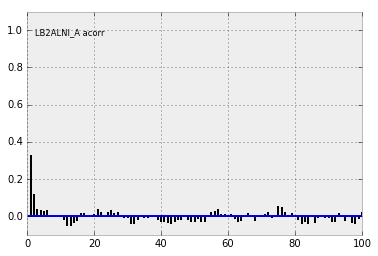

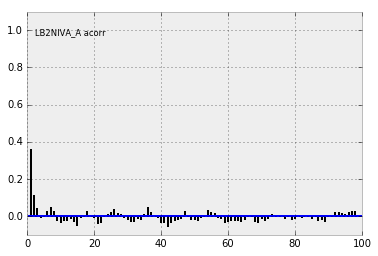

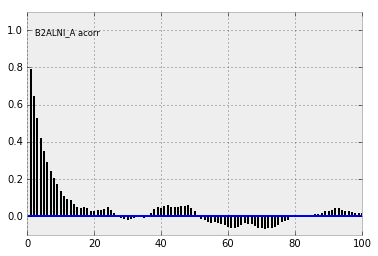

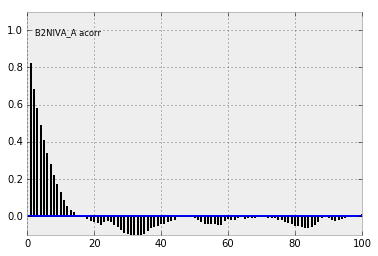

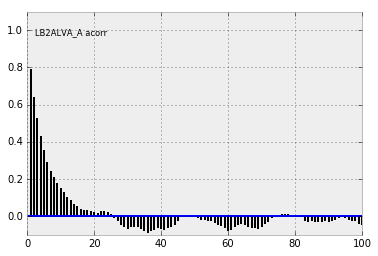

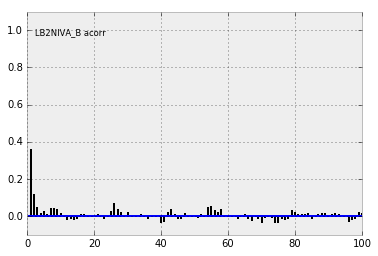

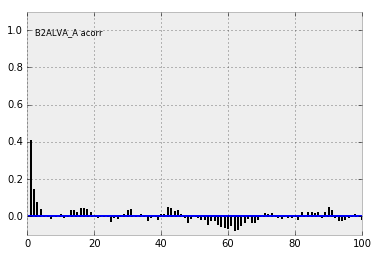

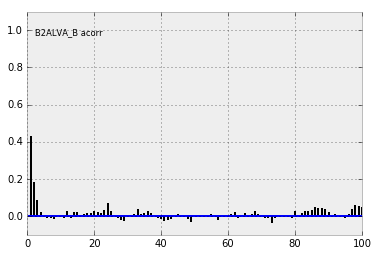

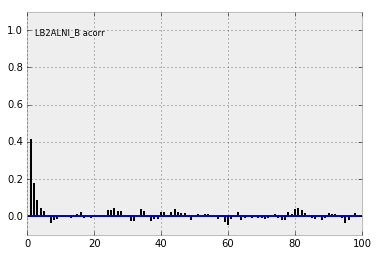

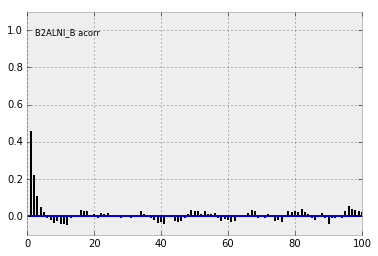

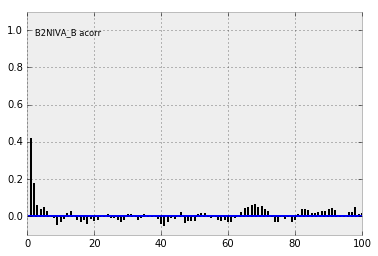

In [6]:
pymc.Matplot.autocorrelation(MDL, format='eps', path='output-results/{0}/{1}/'.format(PHASE, timestamp))

Could not calculate Gelman-Rubin statistics. Requires multiple chains of equal length.


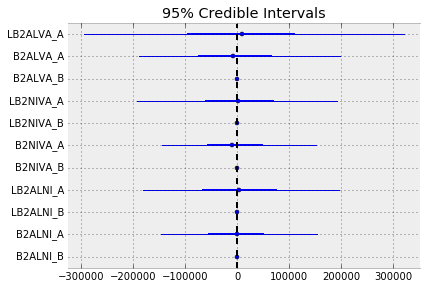

In [7]:
pymc.Matplot.summary_plot(params, format='eps', name=SYSTEM+'-'+PHASE+'-parameters',
                          path='output-results/{0}/{1}/'.format(PHASE, timestamp))

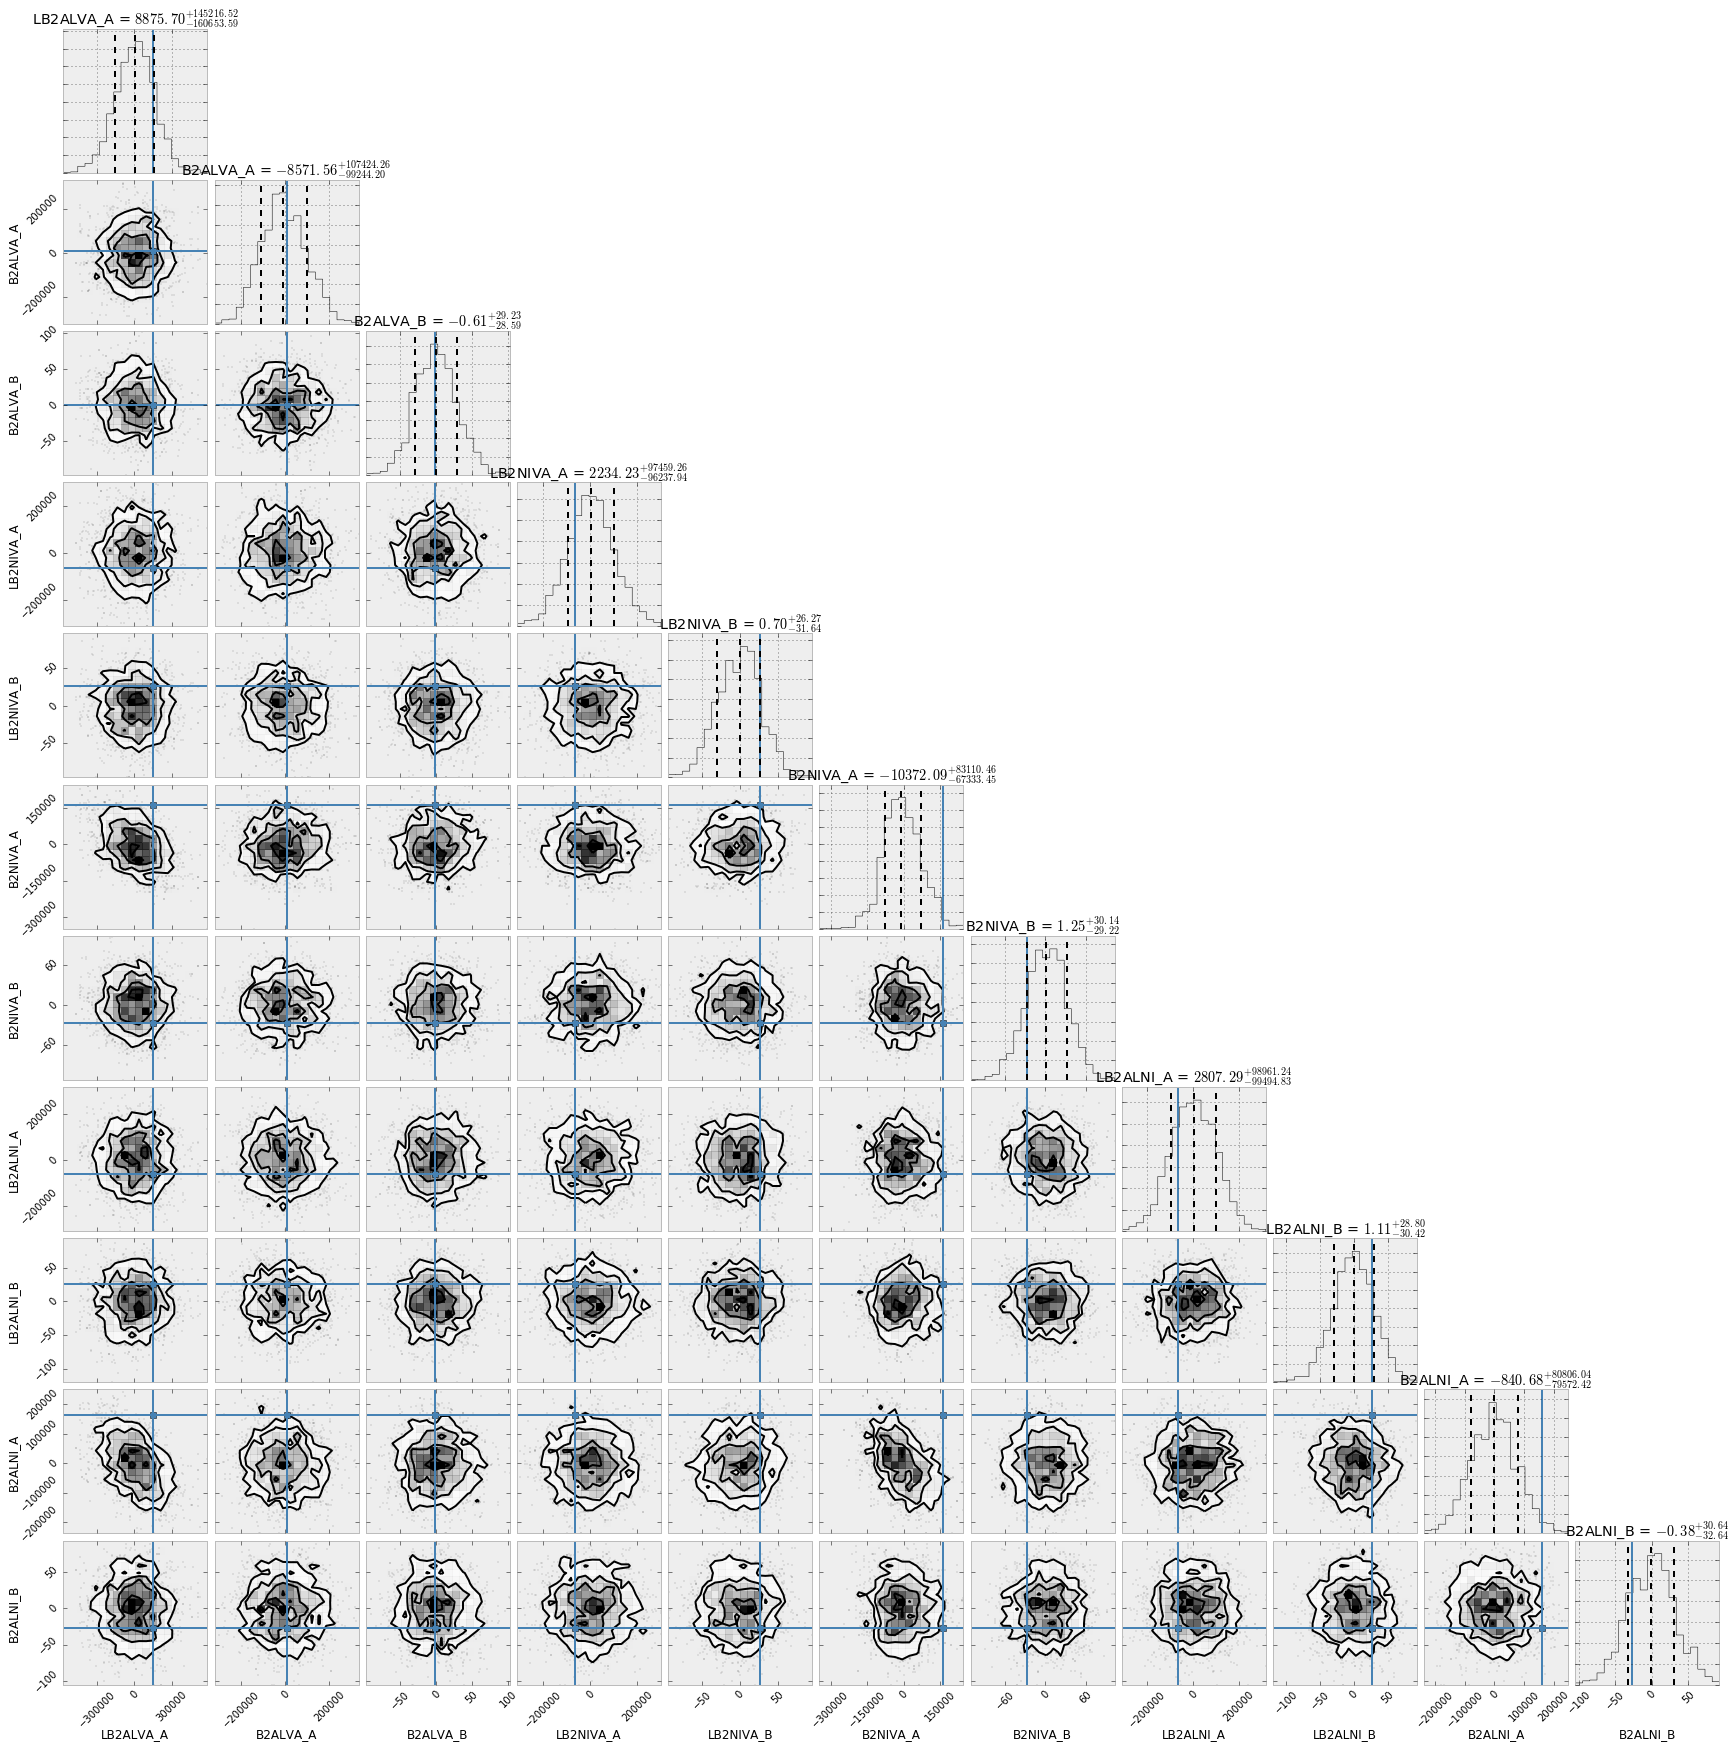

In [20]:
from corner import corner
from itertools import chain
data = np.vstack(chain([i.trace() for i in params])).T
figure = corner(data, labels=[str(i) for i in params],
                quantiles=[0.16, 0.5, 0.84],
                truths=[150000, 10000, -1, -64024.38, 26.49419, 162397.3, -27.40575,
                        -64024.38, 26.49419, 162397.3, -27.40575, -52440.88, 11.30117,
                        -152397.3, 26.40575],
                show_titles=True, title_args={"fontsize": 40})
figure.savefig('output-results/{0}/{1}/{0}-{2}-corner.pdf'.format(PHASE, timestamp, SYSTEM))
figure.show()

In [10]:
%matplotlib inline
#figures = list(plot_results(datasets, params))
#figures[0].savefig('output-results/{0}/{1}/{0}-{2}-heatcapacity.eps'.format(PHASE, timestamp, SYSTEM))

In [11]:
MDL.write_csv('output-results/{0}/{1}/{0}-{2}-param-summary.csv'.format(PHASE, timestamp, SYSTEM))
MDL.summary()


LB2ALNI_A:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	2532.805         97960.814        2854.637[-180819.402  194666.866]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	-192299.759      -66672.86       3008.921       73851.314     190337.318
	

LB2NIVA_A:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	4542.526         99406.481        2616.833[-193047.367  191893.383]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	-187427.799      -60466.019      2235.287       68634.533     201762.886
	

B2ALNI_A:
 
	Mean             SD               MC Error        95% HPD interval